# Sentiment analysis using simplified self-attention


IMPORTANT: Instead of calculating the self-attention embeddings inside the neural network as a self-attention layer, here we calculate the new embeddings before training the network, as a preprocess. This way, we only calculate this new embeddings once, instead of calculating it once every epoch. This was done with the aim of reducing the computational resources, since the main goal of this activity, besides learning about self-attention, is the effiency of the code.

Author: **Rafael Ito**  
e-mail: ito.rafael@gmail.com

## 0. Dataset and Description

**Name:**  IMDb  
**Description:** this notebook uses the IMDb dataset which contains movie reviews classified as either positive or negative review. The aim is to perform a supervised learning for sentiment classification using as features the self-attention of the GloVe embeddings.

## 1. Libraries and packages

### 1.1 Install packages

In [1]:
!pip install -q \
    numpy       \
    torch       \
    sklearn     \
    skorch      \
    matplotlib  

     |████████████████████████████████| 112kB 7.3MB/s 


### 1.2 Import libraries

In [2]:
#-------------------------------------------------
# general
#-------------------
import numpy as np
import pandas as pd
import nltk
import re
#-------------------------------------------------
# PyTorch
#-------------------
import torch
from torch.utils.data import TensorDataset
from torchtext.vocab import GloVe
import torch.nn.functional as F
#-------------------------------------------------
# skorch
#-------------------
#from skorch import NeuralNetClassifier
#-------------------------------------------------
# scikit-learn
#-------------------
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import OneHotEncoder
# metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
#-------------------------------------------------
# data visualization
#-------------------
import matplotlib.pyplot as plt
import seaborn as sns
#-------------------------------------------------
# additional config
#-------------------
# random seed generator
torch.manual_seed(42);

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


### 1.3 Check device

In [3]:
device = torch.device('cpu')
if torch.cuda.is_available():
    device = torch.device('cuda')
print('Device:', device)

Device: cuda


### 1.4 Constants definition

In [0]:
# choose if the features to be used will be TF-IDF or word embeddings
TFIDF = True
#TFIDF = False
#-------------------
# define the size of embeddings (options: 50, 100, 200, 300)
EMBEDDING_DIM = 300

## 2. Custom functions and classes

### 2.1 Functions

Function that calculates the number of parameters of a network

In [0]:
'''
description:
    - given a model, this function returns its number of parameters (weight, bias)
#-------------------
positional args:
    - model [torch.nn.Module]: instance of the network
optional args:
    - verbose (default=False) [bool]: if True, print a report with the parameters of each layer
#-------------------
return:
    - [int] total parameters of the network
''';

In [0]:
def nparam(model, verbose=False):
    if(verbose):
        i = 0
        total = 0
        for name, param in model.named_parameters():
            if (param.requires_grad):
                #print('layer ', i, ' name: ', name)
                j = 1
                for dim in param.data.shape:
                    j = j * dim
                print('layer ', i, ': ', name, '; parameters: ', j, sep='')
                i += 1
                total += j
        print('total parameters = ', total)
        return
    else:
        #pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
        return sum(p.numel() for p in model.parameters())

Function to plot confusion matrix

In [0]:
'''
description:
    - this function plots the confusion matrix (normalized or not) 
    using Matplotlib and seaborn in a nice way using heatmap.
#-------------------
positional args:
    - confusion_matrix  [numpy.ndarray]:    ex.: array([[88, 19],[22, 71]])
    - class_names       [list of str]:      ex.: ['negative', 'positive']

optional args:
    - title     (default=None)          [str]:      title of the plot
    - normalize (default=False)         [bool]:     values raw or normalized
    - cmap      (default=plt.cm.Blues)     \
       [matplotlib.colors.LinearSegmentedColormap]: colormap to be used
    - fig_size   (default=(10,7))        [tuple]:    size of the figure
    - fontsize  (default=14)            [int]:      size of the text
#-------------------
return:
  - fig [matplotlib.figure.Figure]: confusion matrix plotted in a nice way!
''';

In [0]:
#https://github.com/ito-rafael/machine-learning/blob/master/snippets/confusion_matrix.py
def print_confusion_matrix(confusion_matrix, class_names, title=None, normalize=False, cmap=plt.cm.Blues, figsize = (10,7), fontsize=14):
    # normalized or raw CM
    if normalize:
        confusion_matrix = confusion_matrix.astype('float') / confusion_matrix.sum(axis=1)[:, np.newaxis]
        fmt = '.2f'
    else:
        fmt = 'd'
    #----------------------------
    df_cm = pd.DataFrame(confusion_matrix, index=class_names, columns=class_names)
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt=fmt, cmap=cmap)
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    #----------------------------
    # fix matplotlib 3.1.1 bug
    #heatmap.get_ylim() --> (5.5, 0.5)
    #heatmap.set_ylim(6.0, 0)
    #----------------------------
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.title(title)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    return fig

Function that preprocess a document, returning the mean of word embeddings

In [0]:
'''
description:
    this function receives as parameter a corpus [list of lists] and do the following:
      - convert to lower case,
      - split in tokens,
      - remove stop words
return:
    the same corpus preprocessed
''';

In [10]:
def pre_processing(corpus, stopwords, embedding=GloVe(name='6B', dim=300, cache='./glove_dir')):
    corpus_pp = []
    for sentence in corpus:
        sentence = sentence.lower()                 # convert to lower case
        sentence = re.sub("[^\w]", " ",  sentence)  # match word characters [a-zA-Z0-9_]
        sentence = sentence.split()                 # split in tokens
        #---------------------------
        sentence_pp = []
        for token in sentence:
            # remove stop words
            if token not in stopwords: 
                sentence_pp.append(token)
        corpus_pp.append(sentence_pp)
    return corpus_pp

./glove_dir/glove.6B.zip: 862MB [06:31, 2.20MB/s]                           
100%|█████████▉| 399630/400000 [00:38<00:00, 9998.81it/s] 

### 2.2 Classes

Class used for training in training loop

In [0]:
'''
description:
    this class is used during the training loop for TRAINING

parameters:
    - device
    - model
    - dataloader
    - loss_function
    - optimizer

return:
    np.mean(loss_his()) [numpy.float64]: mean of losses of all mini-batches in one epoch
    score_train.item()  [float]:         accuracy calculated over one epoch  
''';

In [0]:
class TrainingLoop():
    def __init__(self, device, model, dataloader, loss_function, optimizer):
        self.device = device
        self.model = model
        self.dataloader = dataloader
        self.loss_function = loss_function
        self.optimizer = optimizer

    def __call__(self):
        # training mode
        self.model.train()
        loss_his = np.zeros(len(self.dataloader))
        score_train = 0.
        for b_i, (b_x, b_y) in enumerate(self.dataloader):   # for each training step
            b_x, b_y = b_x.to(self.device), b_y.to(self.device)
            y_logitos = self.model(b_x)
            loss = self.loss_function(y_logitos, b_y)
            self.optimizer.zero_grad()  # clear gradients for next train
            loss.backward()             # backpropagation, compute gradients
            self.optimizer.step()        # apply gradients
            #-------------------
            y_pred = torch.argmax(y_logitos, dim=1)
            score_train += (b_y == y_pred).sum()
            loss_his[b_i] = loss.item()
        return np.mean(loss_his), score_train.item()

Class used for validation in training loop

In [0]:
'''
description:
    this class is used during the training loop for VALIDATION

parameters:
    - device
    - model
    - dataloader
    - loss_function

return:
    np.mean(loss_his()) [numpy.float64]: mean of losses of all mini-batches in one epoch
    score_valid.item()  [float]:         accuracy calculated over one epoch  
''';

In [0]:
class ValidatingLoop():
    def __init__(self, device, model, dataloader, loss_function):
        self.device = device
        self.model = model
        self.dataloader = dataloader
        self.loss_function = loss_function

    def __call__(self):
        # evaluation mode
        self.model.eval()
        loss_his = np.zeros(len(self.dataloader))
        score_valid = 0.
        for b_ival, (b_xval, b_yval) in enumerate(self.dataloader):
            b_xval, b_yval = b_xval.to(self.device), b_yval.to(self.device)
            y_logitos = self.model(b_xval)
            loss_valid = self.loss_function(y_logitos, b_yval)
            yval_pred = torch.argmax(y_logitos, dim=1)
            score_valid += (b_yval == yval_pred).sum()
            loss_his[b_ival] = loss_valid.item()
        return np.mean(loss_his), score_valid

## 3. Dataset Pre-processing

### 3.1 Download dataset

In [15]:
# download dataset
!wget -nc http://files.fast.ai/data/examples/imdb_sample.tgz
!tar -xzf imdb_sample.tgz

--2020-04-09 02:04:39--  http://files.fast.ai/data/examples/imdb_sample.tgz
Resolving files.fast.ai (files.fast.ai)... 67.205.15.147
Connecting to files.fast.ai (files.fast.ai)|67.205.15.147|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 571827 (558K) [application/x-gtar-compressed]
Saving to: ‘imdb_sample.tgz’

imdb_sample.tgz     100%[===================>] 558.42K  1.27MB/s    in 0.4s    

2020-04-09 02:04:40 (1.27 MB/s) - ‘imdb_sample.tgz’ saved [571827/571827]



### 3.2 Download embeddings

In [0]:
# !wget -nc http://nlp.stanford.edu/data/glove.6B.zip
# !unzip -o glove.6B.zip -d glove_dir

Loading word embeddings with gensin

In [0]:
# import gensim.downloader as api

# word2vec_model = api.load("glove-wiki-gigaword-300")
# print(word2vec_model.vectors.shape)
# print(word2vec_model.index2word)

Loading word embeddings with torchtext

In [0]:
from torchtext.vocab import GloVe
glove_embedding = GloVe(name='6B', dim=EMBEDDING_DIM, cache='./glove_dir')

In [19]:
print(glove_embedding.vectors.shape)
print('First 20 words and its index:', list(glove_embedding.stoi.items())[:20])

torch.Size([400000, 300])
First 20 words and its index: [('the', 0), (',', 1), ('.', 2), ('of', 3), ('to', 4), ('and', 5), ('in', 6), ('a', 7), ('"', 8), ("'s", 9), ('for', 10), ('-', 11), ('that', 12), ('on', 13), ('is', 14), ('was', 15), ('said', 16), ('with', 17), ('he', 18), ('as', 19)]


In [20]:
glove_embedding['the'].shape

torch.Size([300])

### 3.3 Dataset preparation

In [0]:
# read csv spreadsheet
df = pd.read_csv('imdb_sample/texts.csv')

training-validation split

In [22]:
train = df[df['is_valid'] == False]
valid = df[df['is_valid'] == True]
#---------------------------
print('treino.shape:', train.shape)
print('valid.shape:', valid.shape)

treino.shape: (800, 3)
valid.shape: (200, 3)


Input

In [23]:
# slice pandas dataframe
X_train_pd = train['text']
X_valid_pd = valid['text']
#---------------------------
print(type(X_train_pd))

<class 'pandas.core.series.Series'>


Convert from pandas to list and preprocess (remove stopwords, tokenize, lowercase)

In [24]:
# convert from pandas to list
X_train_list = X_train_pd.tolist()
X_valid_list = X_valid_pd.tolist()
print(type(X_train_pd))
print(type(X_train_list))

<class 'pandas.core.series.Series'>
<class 'list'>


In [25]:
# get English stopwords
nltk.download('stopwords')
stopwords = nltk.corpus.stopwords.words('english')
# print first 15 stop words
print(stopwords[:10])
# print number of stopwords
len(stopwords)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]


179

In [26]:
X_train_tokens = pre_processing(X_train_list, stopwords, glove_embedding)
X_valid_tokens = pre_processing(X_valid_list, stopwords, glove_embedding)
#---------------------------
print(X_train_list[0])
X_train_tokens[0][:5]

Un-bleeping-believable! Meg Ryan doesn't even look her usual pert lovable self in this, which normally makes me forgive her shallow ticky acting schtick. Hard to believe she was the producer on this dog. Plus Kevin Kline: what kind of suicide trip has his career been on? Whoosh... Banzai!!! Finally this was directed by the guy who did Big Chill? Must be a replay of Jonestown - hollywood style. Wooofff!


['un', 'bleeping', 'believable', 'meg', 'ryan']

Get the mean length of the sentences of the corpus

In [27]:
# calculate the length of each sentence
#---------------------------
# training set
N_SAMPLES = len(X_train_tokens)
length = torch.zeros(N_SAMPLES)
for i, sentence in enumerate(X_train_tokens):
    length[i] = len(sentence)
#---------------------------
# validaton set
N_VALID = len(X_valid_tokens)
length_valid = torch.zeros(N_VALID)
for i, sentence in enumerate(X_valid_tokens):
    length_valid[i] = len(sentence)
#---------------------------
# get the mean length of all sentences
max_length = torch.mean(length)
max_length = int(torch.round(max_length).item())
#---------------------------
print('length of sentences:', length[:10])
print('mean length of sentences:', max_length)

length of sentences: tensor([ 42., 177.,  94.,  79., 160.,  69.,  95., 232., 106.,  75.])
mean length of sentences: 131


## Self-Attention Layer (as function)


Truncate sentences to max_length tokens and convert them to vectors using Glove

In [28]:
# training set
network_input = torch.zeros(N_SAMPLES, max_length, EMBEDDING_DIM)   # in this case, (800 x 131 x 300)
#---------------------------
for s, sentence in enumerate(X_train_tokens):
    for t, token in enumerate(sentence):
        # truncate sentence in max_length
        if (t == max_length):
            break
        # lookup table
        network_input[s][t] = glove_embedding[token]
#---------------------------
print(network_input.shape)

torch.Size([800, 131, 300])


In [29]:
# validation set
network_valid = torch.zeros(N_VALID, max_length, EMBEDDING_DIM)   # in this case, (800 x 131 x 300)
#---------------------------
for s, sentence in enumerate(X_valid_tokens):
    for t, token in enumerate(sentence):
        # truncate sentence in max_length
        if (t == max_length):
            break
        # lookup table
        network_valid[s][t] = glove_embedding[token]
#---------------------------
print(network_valid.shape)

torch.Size([200, 131, 300])


### Self-Attention using the Loop Approach

In [0]:
'''
#---------------------------
shapes:
  - corpus_tokenized: (800 x 131 x 300)
  - seq: (131 x 300)
  - q, k, v: (1 x 300)
#---------------------------
input:
  - corpus_tokenized: (800 x 131 x 300)
    embeddings of the first "max_length" words of the sentence, 
    truncated if bigger or completed with <PAD> if smaller.
#---------------------------
return:
  - net_inp_sa: (800 x 131 x 300)
  new embeddings calculated with self-attention algorithm
'''
def self_attention_loop(corpus_tokenized):
    N_SAMPLES = len(corpus_tokenized)
    L = len(corpus_tokenized[0])
    EMBEDDING_DIM = len(corpus_tokenized[0][0])
    #---------------------------
    net_inp_sa = torch.zeros(N_SAMPLES, L, EMBEDDING_DIM)   # in this case, (800 x 131 x 300)
    rafael = []
    ito = []
    for index, seq in enumerate(corpus_tokenized):
        for q_idx, q in enumerate(seq):
            #---------------------------
            # calculate scores and probabilities
            scores = torch.zeros(L) # shape: (131)
            for i, k in enumerate(seq):
                # if PAD, force scores = 0 to be very negative (-1e10), 
                # so the probability is almost 0
                if (torch.nonzero(k).size(0) == 0):
                    scores[i] = -1e10
               # else, calculate score normally
                else:
                    scores[i] = torch.matmul(q, k.T)
            probs = F.softmax(scores, dim=0) # shape: (131 x 1)
            #---------------------------
            # probabilities multiplication and mean
            new_embedding = 0
            for j, v in enumerate(seq):
                new_embedding += v * probs[j]
            #---------------------------
            # save new embedding
            net_inp_sa[index][q_idx] = new_embedding
    return net_inp_sa

### Self-Attention using the Matrix Approach

In [0]:
def self_attention_matrix(corpus_tokenized):
    N_SAMPLES = len(corpus_tokenized)
    L = len(corpus_tokenized[0])
    EMBEDDING_DIM = len(corpus_tokenized[0][0])
    #---------------------------
    net_inp_sa = torch.zeros(N_SAMPLES, L, EMBEDDING_DIM)   # in this case, (800 x 131 x 300)
    for index, seq in enumerate(corpus_tokenized):
        X = seq.squeeze() # new shape: (131 x 300)
        Q = K = V = X
        scores = torch.matmul(Q, K.T)
        scores[scores == 0] = -1e10  # force scores = 0 to be very negative (-1e10), so prob is almost 0
        probs = F.softmax(scores, dim=1)
        net_inp_sa[index] = torch.matmul(probs, V)
    return net_inp_sa

Testing self attention "layer" using loop approach for only 10 samples

In [32]:
%%time
sa_loop = self_attention_loop(network_input[:10])
print(sa_loop.shape)

100%|█████████▉| 399630/400000 [00:50<00:00, 9998.81it/s]

torch.Size([10, 131, 300])
CPU times: user 4.97 s, sys: 1.55 ms, total: 4.97 s
Wall time: 4.99 s


Now we will test the same self attention "layer", but using the matrix approach for all the dataset (800 samples)

In [33]:
%%time
sa_matrix = self_attention_matrix(network_input[:])
print(sa_matrix.shape)

torch.Size([800, 131, 300])
CPU times: user 495 ms, sys: 46.7 ms, total: 541 ms
Wall time: 560 ms


The first approach took 6.55 seconds for only 10 samples. If all the dataset was passed to this function, it would take approximately 6.55 * 80 = 524 seconds to process all data!  
Instead, the matrix approach took only 731 ms for all the dataset. This means the second approach is more than 700 times faster!

In [34]:
# comparing both approaches
print(sa_loop[:2][:2][:1])
print('')
print(sa_matrix[:2][:2][:1])

tensor([[[ 0.4426, -0.1797, -0.2702,  ..., -0.3162, -0.3966,  0.0611],
         [ 0.3920, -0.3462, -0.2514,  ..., -0.1174,  0.4845, -0.4879],
         [ 0.0335,  0.1577, -0.0917,  ...,  0.6841,  0.0333,  0.3262],
         ...,
         [ 0.0744,  0.0789, -0.0398,  ..., -0.0272, -0.0315,  0.0758],
         [ 0.0744,  0.0789, -0.0398,  ..., -0.0272, -0.0315,  0.0758],
         [ 0.0744,  0.0789, -0.0398,  ..., -0.0272, -0.0315,  0.0758]]])

tensor([[[ 0.4426, -0.1797, -0.2702,  ..., -0.3162, -0.3966,  0.0611],
         [ 0.3920, -0.3462, -0.2514,  ..., -0.1174,  0.4845, -0.4879],
         [ 0.0335,  0.1577, -0.0917,  ...,  0.6841,  0.0333,  0.3262],
         ...,
         [ 0.0233,  0.0247, -0.0125,  ..., -0.0085, -0.0098,  0.0237],
         [ 0.0233,  0.0247, -0.0125,  ..., -0.0085, -0.0098,  0.0237],
         [ 0.0233,  0.0247, -0.0125,  ..., -0.0085, -0.0098,  0.0237]]])


In [35]:
# MSE between both approaches for the first 10 samples out of 800
torch.nn.functional.mse_loss(sa_loop, sa_matrix[:10])

tensor(0.0011)

In [36]:
# doing the same for the validation set
%%time
sa_matrix_valid = self_attention_matrix(network_valid)
print(sa_matrix_valid.shape)

torch.Size([200, 131, 300])
CPU times: user 116 ms, sys: 14.1 ms, total: 130 ms
Wall time: 131 ms


In [0]:
def masked_mean(sa_embeddings, length):
    # create mask matrix
    mask = torch.ones(sa_embeddings.shape[0], sa_embeddings.shape[1])   # shape: (800 x 131)
    # clear entries for PAD
    for i, L in enumerate(length):
        mask[i][int(L.item()):] = 0
        return mask
    #---------------------------
    # use mask to calculate mean
    masked_mean = mask.unsqueeze(dim=2) * sa_embeddings
    masked_mean = torch.mean(masked_mean, dim=2)
    return masked_mean

In [38]:
X_train_sa = masked_mean(sa_matrix, length)
X_valid_sa = masked_mean(sa_matrix_valid, length_valid)
#---------------------------
print(X_train_sa.shape)
print(X_valid_sa.shape)

torch.Size([800, 131])
torch.Size([200, 131])


Target

In [39]:
# get the label as string (either 'positive' or 'negative')
y_train_str = train['label']
y_valid_str = valid['label']
#---------------------------
# convert from string to boolean
mapping = {'positive': True, 'negative': False}
y_train_pd = y_train_str.map(mapping)
y_valid_pd = y_valid_str.map(mapping)
#---------------------------
print(y_train_str[:1].values)
print(y_train_pd[:1].values)

['negative']
[False]


In [40]:
# convert from pandas series to PyTorch
y_train = torch.LongTensor(y_train_pd.values)
y_valid = torch.LongTensor(y_valid_pd.values)
#---------------------------
print('type of "y_train_pd":', type(y_train_pd))
print('type of "y_train":', type(y_train))
print(y_train.shape)

type of "y_train_pd": <class 'pandas.core.series.Series'>
type of "y_train": <class 'torch.Tensor'>
torch.Size([800])


## Dataset

### 3.3 PyTorch dataset creation

In [0]:
# dataset using Word Embeddings
ds_train = TensorDataset(X_train_sa, y_train)
ds_valid = TensorDataset(X_valid_sa, y_valid)

### 3.4 PyTorch loader creation

- BATCH_SIZE definition
- training dataset
- validation dataset

In [0]:
BATCH_SIZE = 100
#-------------------------------------------------
# training data loader
dl_train = torch.utils.data.DataLoader(
            dataset=ds_train, 
            drop_last = False,
            shuffle = True,
            batch_size = BATCH_SIZE)
#-------------------------------------------------
# validation data loader
dl_valid =  torch.utils.data.DataLoader(
            dataset = ds_valid,
            drop_last = False,
            shuffle = False,
            batch_size = BATCH_SIZE)

### 3.5 Verifying shape, batch data type from loader and optionally its visualization

In [43]:
tx, ty = iter(dl_train).next()
print('train:', tx.shape, tx.dtype, ty.shape, ty.dtype)
tx, ty = iter(dl_valid).next()
print('val:', tx.shape, tx.dtype, ty.shape, ty.dtype)
print('last batch size:', len(ds_train)%BATCH_SIZE, len(ds_valid)%BATCH_SIZE)

train: torch.Size([100, 131]) torch.float32 torch.Size([100]) torch.int64
val: torch.Size([100, 131]) torch.float32 torch.Size([100]) torch.int64
last batch size: 0 0


## 4. Network Model

### 4.1 Network class definition

In [0]:
class NN(torch.nn.Module):
    def __init__(self, inputs, layer1_neurons, layer2_neurons):
        super(NN, self).__init__()
        self.inputs = inputs
        self.layer1_neurons = layer1_neurons
        self.layer2_neurons = layer2_neurons

        self.dropout = torch.nn.Dropout(0.5)
        self.layer1 = torch.nn.Linear(in_features=self.inputs,  out_features=self.layer1_neurons)
        self.layer2 = torch.nn.Linear(in_features=self.layer1_neurons,  out_features=self.layer2_neurons)
        self.layer3 = torch.nn.Linear(in_features=self.layer2_neurons,  out_features=2)

    def forward(self, x):
        #-------------------
        # dense layer, ReLU, dropout
        x = self.layer1(x)
        x = F.relu(x)
        #x = self.dropout(x)
        #-------------------
        # dense layer, ReLU, dropout
        x = self.layer2(x)
        x = F.relu(x)
        #x = self.dropout(x)
        #-------------------
        # dense layer
        x = self.layer3(x)
        #-------------------
        return x

### 4.2 Network instantiation

In [45]:
model = NN(inputs=max_length, layer1_neurons=500, layer2_neurons=500)
model.to(device)

NN(
  (dropout): Dropout(p=0.5, inplace=False)
  (layer1): Linear(in_features=131, out_features=500, bias=True)
  (layer2): Linear(in_features=500, out_features=500, bias=True)
  (layer3): Linear(in_features=500, out_features=2, bias=True)
)

### 4.3 Network predict with few samples of batch from loader

In [46]:
model(ds_train[0][0].to(device))

tensor([0.0336, 0.0095], device='cuda:0', grad_fn=<AddBackward0>)

## 5. Network training

### 5.1 Training definitions

- number of epochs
- optimizer and LR (learning rate)
- loss function


In [0]:
# Training parameters
EPOCH = 1000
LR = 0.1
PATIENCE = 100
loss_func = torch.nn.CrossEntropyLoss()
opt = torch.optim.SGD(model.parameters(), lr=LR)
#-------------------
best_valid_loss = 999_999.
train_samples = len(ds_train)
valid_samples = len(ds_valid)
#-------------------
trainer = TrainingLoop(device, model, dl_train, loss_func, opt)
validator = ValidatingLoop(device, model, dl_valid, loss_func)
#-------------------
# loss history
loss_train_his = []
loss_valid_his = []
acc_train_his = []
acc_valid_his = []

### 5.2 Training loop

In [48]:
for epoch in range(EPOCH):
    # training
    his_train = trainer()
    loss_train_his.append(his_train[0])
    acc_train_his.append(his_train[1] / train_samples)
    #-------------------
    # validating
    his_valid = validator()
    loss_valid_his.append(his_valid[0])
    acc_valid_his.append(his_valid[1] / valid_samples)
    #-------------------------------------------------
    # early stopping: check if new validation accuracy occurred
    if loss_valid_his[-1] < best_valid_loss:
        # print('New best loss in validation set!', end=' ')
        best_valid_loss = loss_valid_his[-1]
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter == PATIENCE:
            print('Early stopping:', PATIENCE, 'iterations without validation loss improve')
            break
    #-------------------------------------------------
    if not (epoch % 10):
        print('epoch =', epoch, end='; ')
        print('loss_train = {0:.4f}'.format(loss_train_his[-1]), end='; ')
        print('loss_val = {0:.4f}'.format(loss_valid_his[-1]), end='; ')
        print('acc_train = {0:.4f}'.format(acc_train_his[-1]), end='; ')
        print('acc_val = {0:.4f}'.format(acc_valid_his[-1]), end='\n')

epoch = 0; loss_train = 0.7149; loss_val = 0.6936; acc_train = 0.4925; acc_val = 0.4650
epoch = 10; loss_train = 0.6940; loss_val = 0.7039; acc_train = 0.5212; acc_val = 0.4650
epoch = 20; loss_train = 0.6930; loss_val = 0.6915; acc_train = 0.5212; acc_val = 0.5350
epoch = 30; loss_train = 0.6928; loss_val = 0.6910; acc_train = 0.4988; acc_val = 0.5350
epoch = 40; loss_train = 0.6926; loss_val = 0.6911; acc_train = 0.5212; acc_val = 0.5350
epoch = 50; loss_train = 0.6924; loss_val = 0.6914; acc_train = 0.5212; acc_val = 0.5350
epoch = 60; loss_train = 0.6929; loss_val = 0.6918; acc_train = 0.5212; acc_val = 0.5350
epoch = 70; loss_train = 0.6927; loss_val = 0.6915; acc_train = 0.5212; acc_val = 0.5350
epoch = 80; loss_train = 0.6927; loss_val = 0.6914; acc_train = 0.5212; acc_val = 0.5350
epoch = 90; loss_train = 0.6925; loss_val = 0.6913; acc_train = 0.5212; acc_val = 0.5350
epoch = 100; loss_train = 0.6922; loss_val = 0.6914; acc_train = 0.5212; acc_val = 0.5350
Early stopping: 100 i

## 6. Training evaluation

- metrics:
  - accuracy
  - confusion matrix
  - others

### 6.1 Training and Validation Losses

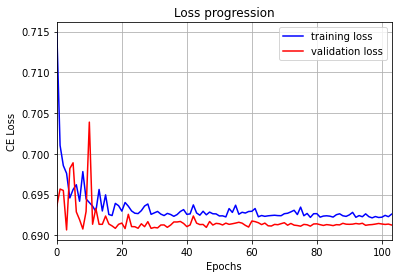

In [49]:
# plot training and validation loss
plt.plot(loss_train_his, label='training loss', color='blue')
plt.plot(loss_valid_his, label='validation loss', color='red')
#-------------------------------------------------
# axis label
plt.xlabel('Epochs')
plt.ylabel('CE Loss')
# title
plt.title('Loss progression')
#-------------------------------------------------
plt.autoscale(axis='x', tight=True) # axis adjust
plt.grid(True) # add grid
plt.legend() # add legend
plt.show()

### 6.2 Zoom at the minimum CE loss in the validation loss curve

Epoch with minimum validation loss = 4


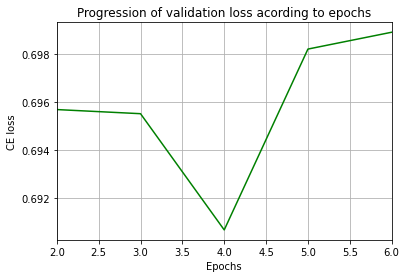

In [50]:
BEST_EPOCH = loss_valid_his.index(min(loss_valid_his)) + 1
print('Epoch with minimum validation loss =', BEST_EPOCH)
#-------------------------------------------------
# plots
plt.plot(range(max(1,BEST_EPOCH-2),min(EPOCH,BEST_EPOCH+3)), loss_valid_his[max(1,BEST_EPOCH-3):min(EPOCH-1,BEST_EPOCH+2)], 'green')
plt.xlabel('Epochs')
plt.ylabel('CE loss')
plt.autoscale(axis='x', tight=True)
plt.title('Progression of validation loss acording to epochs')
plt.grid(True)
plt.show()

### 6.3 Accuracy 

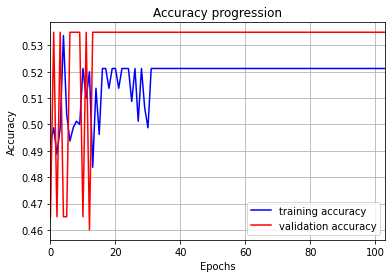

In [51]:
# plot training and validation accuracy
plt.plot(acc_train_his, label='training accuracy', color='blue')
plt.plot(acc_valid_his, label='validation accuracy', color='red')
#-------------------------------------------------
# axis label
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
# title
plt.title('Accuracy progression')
#-------------------------------------------------
plt.autoscale(axis='x', tight=True) # axis adjust
plt.grid(True) # add grid
plt.legend() # add legend
plt.show()

### 6.4 Print the final values of the main training monitoring variables:
- loss function final value:
- metrics final values:

In [52]:
print('last training loss = {0:.4f}'.format(loss_train_his[-1]))
print('last validation loss = {0:.4f}'.format(loss_valid_his[-1]))
print('#-------------------------------------------------')
print('last train accuracy = {0:.4f}'.format(acc_train_his[-1]))
print('last validation accuracy = {0:.4f}'.format(acc_valid_his[-1]))

last training loss = 0.6926
last validation loss = 0.6913
#-------------------------------------------------
last train accuracy = 0.5212
last validation accuracy = 0.5350


## 7. Metrics on test set

For this particular dataset, we will be using the validation set to calculate the performance metrics

In [53]:
# load model in CPU
model.to('cpu');
# evaluation mode
model.eval()

NN(
  (dropout): Dropout(p=0.5, inplace=False)
  (layer1): Linear(in_features=131, out_features=500, bias=True)
  (layer2): Linear(in_features=500, out_features=500, bias=True)
  (layer3): Linear(in_features=500, out_features=2, bias=True)
)

In [0]:
# y_true
y_true = ds_valid[:][1]

In [0]:
# y_pred
score = 0.
y_logitos = model(ds_valid[:][0])
y_pred = torch.argmax(y_logitos, dim=1)

### 7.1 Accuracy

In [56]:
# accuracy
score += (y_true == y_pred).sum()
acc_test = score / len(ds_valid[:][0])
acc_test.item()

0.5350000262260437

### 7.2 Confusion matrix

In [0]:
cm = confusion_matrix(y_true, y_pred)
#classes = enc.get_feature_names()
classes = ['negative', 'positive']

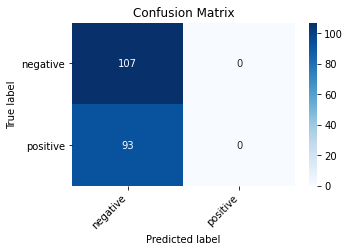

In [58]:
# CM raw
cm_raw = print_confusion_matrix(cm, classes, title='Confusion Matrix', normalize=False, cmap=plt.cm.Blues, fontsize=10, figsize = (5,3))

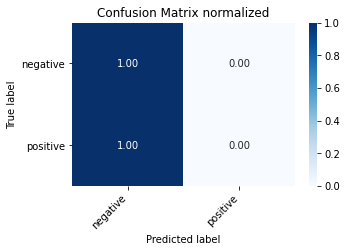

In [59]:
# CM normalized
cm_norm = print_confusion_matrix(cm, classes, title='Confusion Matrix normalized', normalize=True, cmap=plt.cm.Blues, fontsize=10, figsize = (5,3))

### 7.3 F1-score (macro, micro and weighted)

In [0]:
macro = f1_score(y_true, y_pred, average='macro')
micro = f1_score(y_true, y_pred, average='micro')
weighted = f1_score(y_true, y_pred, average='weighted')

In [61]:
print('F1-score macro =', macro)
print('F1-score micro =', micro)
print('F1-score weighted =', weighted)

F1-score macro = 0.3485342019543974
F1-score micro = 0.535
F1-score weighted = 0.37293159609120524


### 7.4 Accuracy and Precision

In [62]:
acc = accuracy_score(y_true, y_pred)
prec = precision_score(y_true, y_pred, average='macro')

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [63]:
print('Accuracy score = ', acc, sep='')
print('Precision score = ', prec, sep='')

Accuracy score = 0.535
Precision score = 0.2675


### 7.5 Precision, Recall and F1-Score for each class

In [64]:
from sklearn.metrics import classification_report as cr
print(cr(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.54      1.00      0.70       107
           1       0.00      0.00      0.00        93

    accuracy                           0.54       200
   macro avg       0.27      0.50      0.35       200
weighted avg       0.29      0.54      0.37       200



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## 8. Number of parameters

In [65]:
nparam(model, verbose=True)

layer 0: layer1.weight; parameters: 65500
layer 1: layer1.bias; parameters: 500
layer 2: layer2.weight; parameters: 250000
layer 3: layer2.bias; parameters: 500
layer 4: layer3.weight; parameters: 1000
layer 5: layer3.bias; parameters: 2
total parameters =  317502


## End of the notebook